<a href="https://colab.research.google.com/github/annabond1001/mosaic-creator-cifar/blob/master/Mosaic_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure

!mkdir -p /tmp/data/
!wget -O /tmp/data/image.jpg https://6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com/267439_ycbojxk4aob.JPG

--2019-05-23 17:38:47--  https://6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com/267439_ycbojxk4aob.JPG
Resolving 6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com (6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com)... 184.27.180.203
Connecting to 6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com (6632a6f1fcad9eea2765-12216f01785e0dac999ff4ef5ef77ab7.ssl.cf2.rackcdn.com)|184.27.180.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102405 (100K) [image/jpeg]
Saving to: ‘/tmp/data/image.jpg’

/tmp/data/image.jpg 100%[===================>] 100.00K  --.-KB/s    in 0.03s   

2019-05-23 17:38:47 (3.66 MB/s) - ‘/tmp/data/image.jpg’ saved [102405/102405]



Image Utils
----

In [0]:
def imread(image_path):
  img = Image.open(image_path)
  img = np.array(img)
  return img/255.0

def imshow(img, title=None, show=True):
  plt.imshow(img)
  if title != None:
     plt.title(title)
  if show:
    plt.show()
      
def pixelate_img(img, kernel_size=10, scale_factor=2):
  final_size = (scale_factor * img.shape[1], scale_factor * img.shape[0])
  img = cv2.resize(img, dsize=final_size, interpolation=cv2.INTER_NEAREST)
  pix_img = skimage.measure.block_reduce(img, (kernel_size, kernel_size, 1), np.max)
  pix_img = cv2.resize(pix_img, dsize=final_size, interpolation=cv2.INTER_NEAREST)
  return pix_img

Download CIFAR10 Dataset
---



In [3]:
from keras.datasets import cifar10
(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()
image_set = np.concatenate([x_train, x_test], axis=0)
image_set = image_set / 255.0
# x_train = x_train / 255.0
# x_test = x_test / 255.0

Using TensorFlow backend.


Map from color to image is created
---



In [4]:
import colorsys
from sortedcontainers import SortedDict


def encode_color(r,g,b):
  h,s,v = colorsys.rgb_to_hsv(r,g,b)
  h = round(h, 2)
  s = round(s, 2)
  v = round(v, 2)
  e = h*10000 + s * 100 + v
  return e

def decode_color(e):
  h = int(e/100)/100.0
  s = int(e-h*10000)/100.0
  v = int((e-h*10000-s*100)*100)/100.0
  r,g,b = colorsys.hsv_to_rgb(h,s,v)
#   print(h,s,v)
#   print(r,g,b)
  return (r,g,b)

def get_dominant_color(img):
  width, height = 150,150
  if np.max(img) <= 1:
    image = Image.fromarray(np.uint8(img*255))
  else:
    image = Image.fromarray(np.uint8(img))
  image = image.resize((width, height),resample = 0)
  pixels = image.getcolors(width * height)

  sorted_pixels = sorted(pixels, key=lambda t: t[0])
  dominant_color = sorted_pixels[-1][1]
  r,g,b = dominant_color
  r /= 255.0
  g /= 255.0
  b /= 255.0
  return (r,g,b)

print("Image set size: ",len(image_set))

color_dict = {}
for i,img in enumerate(image_set):
#   r,g,b = np.mean(img, axis=(0,1))
  r,g,b = get_dominant_color(img)

  e = encode_color(r,g,b)
  color_dict[e] = i

color_dict = SortedDict(color_dict)

Image set size:  60000


Create Mosaic-Image
-----

(1440, 1773, 3)


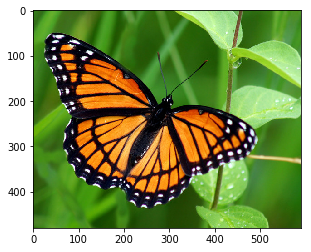

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


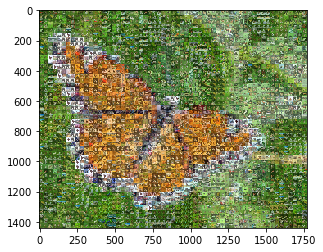

In [5]:
from itertools import islice

def closest(sorted_dict, key):
    assert len(sorted_dict) > 0
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))

def get_image(e):
#   idx = color_dict.get(e, color_dict[min(color_dict.keys(), key=lambda k: abs(k-e))])
  closest_e = closest(color_dict, e)
  return image_set[color_dict[closest_e]]

def create_mosaic(img, kernel_size=30, scale_factor=3):
#   kernel_size = 30
#   scale_factor = 3
  
  pix_img = pixelate_img(img, kernel_size, scale_factor)
  print(pix_img.shape)
  k = kernel_size#*scale_factor
  for i in range(0, pix_img.shape[0], k):
    for j in range(0, pix_img.shape[1], k):
      if(i+k > pix_img.shape[0] or j+k > pix_img.shape[1]):
        break
      
      r,g,b = np.mean(pix_img[i:i+k, j:j+k,...], axis=(0,1))
      v = r + g + b
      
      if (v < 1e-5):# or abs(v-3.0) < 1e-5):
        continue

      r,g,b = pix_img[i,j]
      
      e = encode_color(r,g,b)
      k_img = get_image(e)
      k_img = cv2.resize(k_img, (k,k), interpolation=cv2.INTER_CUBIC)
      pix_img[i:i+k, j:j+k,...] = k_img
  return pix_img

img = imread('/tmp/data/image.jpg')
# input_img = cv2.resize(img, (mosaic_img.shape[1], mosaic_img.shape[0]))

k = 30
s = 3
input_img = pixelate_img(img, k, s)
mosaic_img = create_mosaic(img, k, s)

# wt_mosaic, wt_input = 1, 0
wt_mosaic, wt_input = 0.7, 0.3
mosaic_img2 = (wt_mosaic * mosaic_img + wt_input * input_img) / (wt_mosaic + wt_input)
imshow(img)
imshow(mosaic_img2)

Bigger Picture
------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


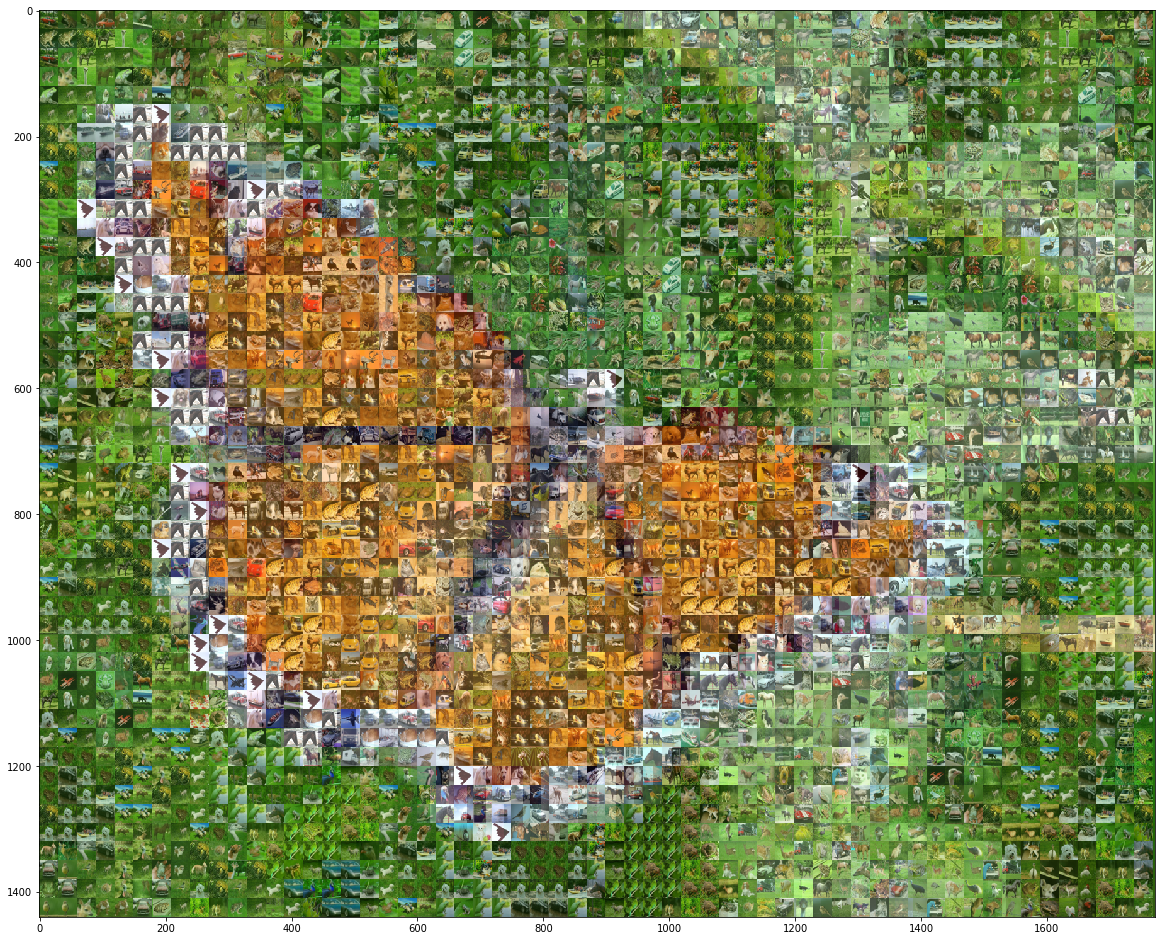

In [6]:
plt.figure(figsize=(20,20))
imshow(mosaic_img2)